# [NTDS'18] Project: Spammer on social network detection 
[ntds'18]: https://github.com/mdeff/ntds_2018


### Jupyter notebook for CLASSIFICATION

## Students

* Team: `20`
* Students: `Fendri Hedi, Jeha Paul, Nguyen Minh Nguyet, Mantonanaki Christina`
* Dataset: `Spammers`

**This notebook take all the created dataset with content and graph based features in order to perform classification**

## A. Importing Library 

In [1]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import networkx as nx
import collections
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, log_loss
import warnings

from sklearn.svm import SVC
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from  sklearn.cluster import KMeans
from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import  average_precision_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

## B. Preparing the matrix for classification 

**Importing the created dataset in the graph_based.ipynb**

In [2]:
nodes_all=pd.read_csv('datasets_final2.csv')

In [3]:
len(nodes_all)

783122

**Since the dataset is very huge , to reduce the computational time, we sub-sampled the datased to 
52 053 nodes with 29440 non spammers and 22613 spammers**

In [4]:
nodes_sub=nodes_all.drop(nodes_all.query("label== 0").sample(frac=0.96).index)

nodes_sub2=nodes_sub.drop(nodes_sub.query("label== 1").sample(frac=0.52).index)
print("Total of reamaing nodes: ",len(nodes_sub2))

Total of reamaing nodes:  52053


In [5]:
print("Number of spammers: ",np.sum(nodes_sub2["label"]==1))
print("Number of non spammers: ",np.sum(nodes_sub2["label"]==0))

Number of spammers:  22613
Number of non spammers:  29440


**Create the numpy matrix for classification**

In [6]:
labels_train=nodes_sub2['label']
nodes_train=nodes_sub2.drop(['label'],axis=1)
nodes_for_train=nodes_train['node'].values
nodes_train=nodes_train.drop(['node'],axis=1)

In [7]:
nodes_train=nodes_train.drop(['out_deg_1'],axis=1)
nodes_train=nodes_train.drop(['out_deg_2'],axis=1)
nodes_train=nodes_train.drop(['out_deg_5'],axis=1)
nodes_train=nodes_train.drop(['out_deg_4'],axis=1)
nodes_train=nodes_train.drop(['out_deg_7'],axis=1)
nodes_train=nodes_train.drop(['in_deg_4'],axis=1)
nodes_train=nodes_train.drop(['in_deg_5'],axis=1)
nodes_train=nodes_train.drop(['in_deg_2'],axis=1)
nodes_train=nodes_train.drop(['in_deg_1'],axis=1)
nodes_train=nodes_train.drop(['in_deg_7'],axis=1)
nodes_train=nodes_train.drop(['deg_4'],axis=1)
nodes_train=nodes_train.drop(['deg_5'],axis=1)
nodes_train=nodes_train.drop(['deg_2'],axis=1)
nodes_train=nodes_train.drop(['deg_1'],axis=1)
nodes_train=nodes_train.drop(['deg_7'],axis=1)

In [8]:
nodes_train.loc[nodes_train['gender'] =='M', 'gender'] = 1
nodes_train.loc[nodes_train['gender'] =='F', 'gender'] = 0

In [9]:
X_all=nodes_train.values
Y_all=labels_train.values
X_all.shape

(52053, 33)

**Filling the missing values (NaN) with the mean on columns**

In [10]:
imp=preprocessing.Imputer(missing_values='NaN', strategy='mean')

In [11]:
#X_all=imp.fit_transform(X_all)

**Or trying to replace NaN by simply zeros**

In [12]:
X_all=np.nan_to_num(X_all)

**Splitting the hole dataset to training and testing with ratio=0.35**

In [13]:
num_test = 0.35
X_train, X_test, y_train, y_test = train_test_split(X_all, Y_all, test_size=num_test, random_state=23)
#X_scaled = preprocessing.scale(X_train)
X_scaled=X_train
y_train.shape

(33834,)

## C. Classification with only content based features

In [14]:
def evaluate_method(y_true,y_pred): 
    """ Evaluating the model using f-measure and accuracy
     Parameters
    ----------
        y_true  : True labels

        y_pred  : Predicted labels
                    
    Returns : None
    
    """
    f1=metrics.f1_score(y_true, y_pred)
    acc=metrics.accuracy_score(y_true, y_pred)
    print("F-measure= ",f1)
    print("Accuracy= ",acc)
    

In [15]:
def plot_roc(y_true,y_pred):
    """ Plotting Roc curve 
     Parameters
    ----------
        y_true  : True labels

        y_pred  : Predicted labels
                    
    Returns : None
    
    """
    auc=roc_auc_score(y_true, y_pred)
    print('auc=',auc)
    fpr,tpr,_=roc_curve(y_true, y_pred)
    plt.plot(fpr,tpr)

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    t=plt.title('Receiver operating characteristic')
    

In [16]:
def plot_prec_recall_curve(y_true, y_pred):
    precision, recall, thresholds=precision_recall_curve(y_true, y_pred)
    plt.plot(recall,precision)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    t=plt.title('Precision recall curve')
    print("AUPR= ",average_precision_score(y_true, y_pred))

## Let's try to classify  using Age range and Gender

In [17]:
X_train_content=X_train[:,1:3]
X_test_content=X_test[:,1:3]
X_test_content.shape

(18219, 2)

### 1) Using K-NN 

**Tuning Hyperparameter K**

In [18]:
neigbors = [1,3,5,7,11,13,15,17,21,31,51,81,101,301,501,701,1001]
param_grid = {'n_neighbors': neigbors}      
print("# Tuning hyper-parameters for f_measure")
print()
clf = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5,
                   scoring='f1')
clf.fit(X_train_content, y_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

# Tuning hyper-parameters for f_measure

Best parameters set found on development set:

{'n_neighbors': 1001}

Grid scores on development set:

0.350 (+/-0.255) for {'n_neighbors': 1}
0.543 (+/-0.070) for {'n_neighbors': 3}
0.535 (+/-0.082) for {'n_neighbors': 5}
0.501 (+/-0.107) for {'n_neighbors': 7}
0.545 (+/-0.071) for {'n_neighbors': 11}
0.536 (+/-0.098) for {'n_neighbors': 13}
0.533 (+/-0.112) for {'n_neighbors': 15}
0.518 (+/-0.097) for {'n_neighbors': 17}
0.528 (+/-0.081) for {'n_neighbors': 21}
0.522 (+/-0.091) for {'n_neighbors': 31}
0.537 (+/-0.077) for {'n_neighbors': 51}
0.537 (+/-0.077) for {'n_neighbors': 81}
0.555 (+/-0.014) for {'n_neighbors': 101}
0.555 (+/-0.014) for {'n_neighbors': 301}
0.555 (+/-0.014) for {'n_neighbors': 501}
0.557 (+/-0.014) for {'n_neighbors': 701}
0.560 (+/-0.013) for {'n_neighbors': 1001}



**Training KNN**

In [19]:
clf3=KNeighborsClassifier(n_neighbors=1001)
clf3.fit(X_train_content, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1001, p=2,
           weights='uniform')

**Prediction and performance evaluation**

In [20]:
y_pred_knn_cont=clf3.predict(X_test_content)
evaluate_method(y_test,y_pred_knn_cont)

F-measure=  0.5616680249932083
Accuracy=  0.6457544321861792


**Plotting roc curve**

auc= 0.6317161169922426


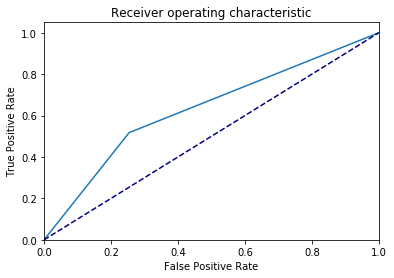

In [21]:
plot_roc(y_test,y_pred_knn_cont)

### 2) Support vector machine classifier

In [22]:
Cs = [0.001, 0.01, 0.1, 1,10,50]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}

In [23]:
warnings.filterwarnings('ignore')


print("# Tuning hyper-parameters")
print()
clf = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5,n_jobs = -1,
                   scoring='f1')
clf.fit(X_train_content, y_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

# Tuning hyper-parameters

Best parameters set found on development set:

{'C': 0.01, 'gamma': 0.1}

Grid scores on development set:

0.000 (+/-0.000) for {'C': 0.001, 'gamma': 0.001}
0.000 (+/-0.000) for {'C': 0.001, 'gamma': 0.01}
0.000 (+/-0.000) for {'C': 0.001, 'gamma': 0.1}
0.470 (+/-0.010) for {'C': 0.001, 'gamma': 1}
0.000 (+/-0.000) for {'C': 0.01, 'gamma': 0.001}
0.000 (+/-0.000) for {'C': 0.01, 'gamma': 0.01}
0.555 (+/-0.014) for {'C': 0.01, 'gamma': 0.1}
0.555 (+/-0.014) for {'C': 0.01, 'gamma': 1}
0.000 (+/-0.000) for {'C': 0.1, 'gamma': 0.001}
0.546 (+/-0.015) for {'C': 0.1, 'gamma': 0.01}
0.555 (+/-0.014) for {'C': 0.1, 'gamma': 0.1}
0.555 (+/-0.014) for {'C': 0.1, 'gamma': 1}
0.546 (+/-0.015) for {'C': 1, 'gamma': 0.001}
0.555 (+/-0.014) for {'C': 1, 'gamma': 0.01}
0.555 (+/-0.014) for {'C': 1, 'gamma': 0.1}
0.555 (+/-0.014) for {'C': 1, 'gamma': 1}
0.546 (+/-0.015) for {'C': 10, 'gamma': 0.001}
0.555 (+/-0.014) for {'C': 10, 'gamma': 0.01}
0.555 (+/-0.014) for {'C': 10

**Training predicting and computing performance**

In [24]:

clf2=SVC(C=50, kernel='rbf', gamma=0.01)
clf2.fit(X_train_content, y_train)
y_pred_svm_content=clf2.predict(X_test_content)
evaluate_method(y_test,y_pred_svm_content)


F-measure=  0.559972251127298
Accuracy=  0.651846972940337


**Plotting ROC curve**

auc= 0.6357840270841616


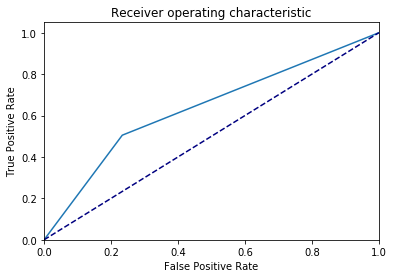

In [25]:
plot_roc(y_test,y_pred_svm_content)

### 3) Linear discriminant analysis (LDA)

In [26]:
clf5=LDA(n_components=1) 
clf5.fit(X_train_content,y_train)

LinearDiscriminantAnalysis(n_components=1, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

**Training, prediction and measuring performance**

F-measure=  0.559972251127298
Accuracy=  0.651846972940337
auc= 0.6357840270841616


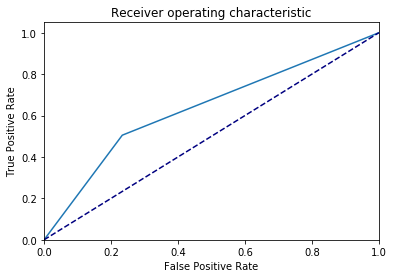

In [27]:
y_pred_lda=clf5.predict(X_test_content)
evaluate_method(y_test,y_pred_lda)
plot_roc(y_test,y_pred_lda)

### 4) Random Forest

**Tuning Hyper-parameters**

In [28]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}


In [29]:
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110], 'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': [100, 200, 300, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [30]:
rf=RandomForestClassifier(bootstrap=True,max_depth=30,max_features=2,min_samples_leaf=30,min_samples_split=100,n_estimators=1000)

In [31]:
rf.fit(X_train_content, y_train)
y_pred_rf=rf.predict(X_test_content)

F-measure=  0.559972251127298
Accuracy=  0.651846972940337
auc= 0.6357840270841616


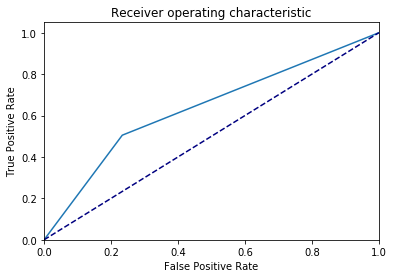

In [32]:
evaluate_method(y_test,y_pred_rf)
plot_roc(y_test,y_pred_rf)

### Let's add time validation as a feature and see the difference 

In [33]:
X_train_content2=X_train[:,0:3]
X_test_content2=X_test[:,0:3]
X_test_content2.shape

(18219, 3)

### 1) K-NN

In [31]:
neigbors = [1,3,5,7,11,13,15,17,21,31,51,81,101,301,501,701,1001]
param_grid = {'n_neighbors': neigbors}      
print("# Tuning hyper-parameters for f_measure")
print()
clf = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5,
                   scoring='f1')
clf.fit(X_train_content2, y_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

# Tuning hyper-parameters for f_measure

Best parameters set found on development set:

{'n_neighbors': 701}

Grid scores on development set:

0.599 (+/-0.027) for {'n_neighbors': 1}
0.627 (+/-0.028) for {'n_neighbors': 3}
0.629 (+/-0.018) for {'n_neighbors': 5}
0.631 (+/-0.025) for {'n_neighbors': 7}
0.637 (+/-0.020) for {'n_neighbors': 11}
0.640 (+/-0.019) for {'n_neighbors': 13}
0.640 (+/-0.025) for {'n_neighbors': 15}
0.641 (+/-0.020) for {'n_neighbors': 17}
0.637 (+/-0.018) for {'n_neighbors': 21}
0.637 (+/-0.021) for {'n_neighbors': 31}
0.638 (+/-0.021) for {'n_neighbors': 51}
0.635 (+/-0.022) for {'n_neighbors': 81}
0.637 (+/-0.016) for {'n_neighbors': 101}
0.634 (+/-0.018) for {'n_neighbors': 301}
0.639 (+/-0.022) for {'n_neighbors': 501}
0.644 (+/-0.017) for {'n_neighbors': 701}
0.637 (+/-0.013) for {'n_neighbors': 1001}



In [59]:
clf3=KNeighborsClassifier(n_neighbors=701)
clf3.fit(X_train_content2, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=701, p=2,
           weights='uniform')

F-measure=  0.6508910312591295
Accuracy=  0.7376365332894231
auc= 0.7179352731706976


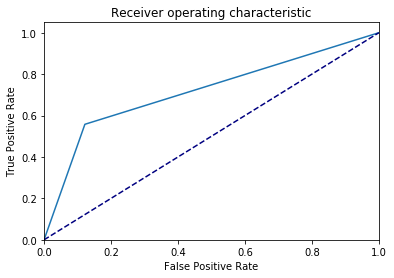

In [60]:
y_pred_knn_cont2=clf3.predict(X_test_content2)
evaluate_method(y_test,y_pred_knn_cont2)
plot_roc(y_test,y_pred_knn_cont2)

### 2) Support vector machine 

F-measure=  0.622345198923123
Accuracy=  0.7228168395630935
auc= 0.7006942830849897


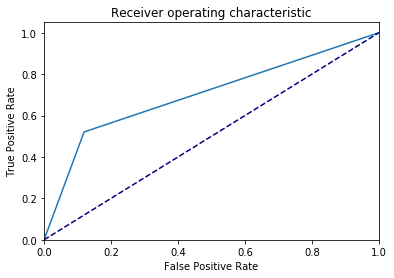

In [61]:
clf2=SVC(C=50, kernel='rbf', gamma=0.1)
clf2.fit(X_train_content2, y_train)
y_pred_svm_content2=clf2.predict(X_test_content2)
evaluate_method(y_test,y_pred_svm_content2)
plot_roc(y_test,y_pred_svm_content2)

### 3) Linear discriminant analysis LDA 

In [37]:
clf5=LDA(n_components=1) 
clf5.fit(X_train_content2,y_train)

LinearDiscriminantAnalysis(n_components=1, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

F-measure=  0.6559635775474749
Accuracy=  0.684779625665514
auc= 0.6848385187991258


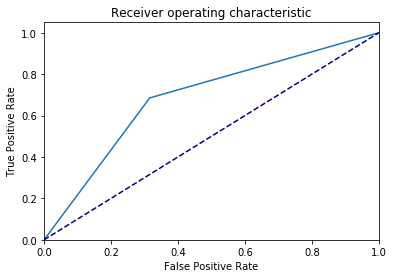

In [38]:
y_pred_lda2=clf5.predict(X_test_content2)
evaluate_method(y_test,y_pred_lda2)
plot_roc(y_test,y_pred_lda2)

### 4) Random forest 

In [39]:
rf=RandomForestClassifier(bootstrap=True,max_depth=30,max_features=2,min_samples_leaf=3,min_samples_split=100,n_estimators=1000)

F-measure=  0.6408147868728782
Accuracy=  0.7386794006257204
auc= 0.7159984825175671


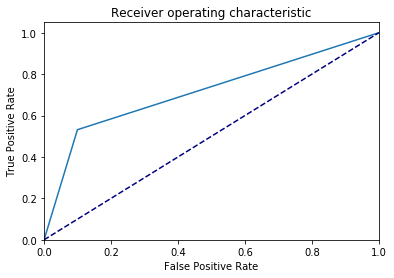

In [40]:
rf.fit(X_train_content2, y_train)
y_pred_rf2=rf.predict(X_test_content2)
evaluate_method(y_test,y_pred_rf2)
plot_roc(y_test,y_pred_rf2)

## D. Classification with content and graph-based features

### 1) Support vector Machine classifier 

**Tuning hyper-parameters using 5fold cross validation**

In [39]:
#grid search parameters 
Cs = [0.001, 0.01, 0.1, 1,10,50]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}

In [40]:
warnings.filterwarnings('ignore')


print("# Tuning hyper-parameters")
print()
clf = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5,n_jobs = -1,
                   scoring='f1')
clf.fit(X_scaled, y_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

# Tuning hyper-parameters

Best parameters set found on development set:

{'C': 10, 'gamma': 0.001}

Grid scores on development set:

0.000 (+/-0.000) for {'C': 0.001, 'gamma': 0.001}
0.000 (+/-0.000) for {'C': 0.001, 'gamma': 0.01}
0.000 (+/-0.000) for {'C': 0.001, 'gamma': 0.1}
0.547 (+/-0.008) for {'C': 0.001, 'gamma': 1}
0.000 (+/-0.000) for {'C': 0.01, 'gamma': 0.001}
0.000 (+/-0.000) for {'C': 0.01, 'gamma': 0.01}
0.557 (+/-0.005) for {'C': 0.01, 'gamma': 0.1}
0.551 (+/-0.009) for {'C': 0.01, 'gamma': 1}
0.000 (+/-0.000) for {'C': 0.1, 'gamma': 0.001}
0.584 (+/-0.007) for {'C': 0.1, 'gamma': 0.01}
0.562 (+/-0.009) for {'C': 0.1, 'gamma': 0.1}
0.608 (+/-0.012) for {'C': 0.1, 'gamma': 1}
0.588 (+/-0.007) for {'C': 1, 'gamma': 0.001}
0.630 (+/-0.013) for {'C': 1, 'gamma': 0.01}
0.617 (+/-0.012) for {'C': 1, 'gamma': 0.1}
0.614 (+/-0.011) for {'C': 1, 'gamma': 1}
0.649 (+/-0.012) for {'C': 10, 'gamma': 0.001}
0.612 (+/-0.008) for {'C': 10, 'gamma': 0.01}
0.617 (+/-0.014) for {'C': 10

**fitting with the optimized parameters and fitting** 

In [41]:
clf2=SVC(C=10, kernel='rbf', gamma=0.001)
clf2.fit(X_train, y_train) 

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

**Predicting and measuring performances** 

F-measure=  0.6495503875968993
Accuracy=  0.6898292990833745
auc= 0.6860720697704211


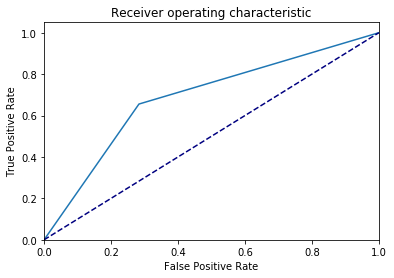

In [42]:
y_pred_svm=clf2.predict(X_test)
evaluate_method(y_test,y_pred_svm)
plot_roc(y_test,y_pred_svm)

**Plotting precision-recall curve**

AUPR=  0.5730018733972672


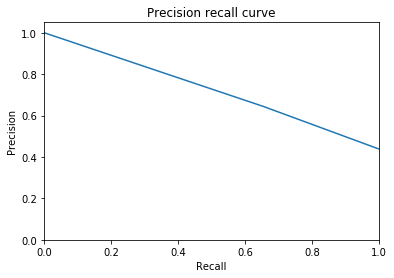

In [43]:
plot_prec_recall_curve(y_test,y_pred_svm)

### 2) K-nearest neighbors 

**Tuning hyper-parameters using 5-fold cross validation** 

In [44]:
KNeighborsClassifier(n_neighbors=5)
neigbors = [15,51,81,101,301,1001]
param_grid = {'n_neighbors': neigbors}      
print("# Tuning hyper-parameters for f_measure")
print()
clf = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5,
                   scoring='f1')
clf.fit(X_scaled, y_train)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

# Tuning hyper-parameters for f_measure

Best parameters set found on development set:

{'n_neighbors': 1001}

Grid scores on development set:

0.632 (+/-0.018) for {'n_neighbors': 15}
0.629 (+/-0.016) for {'n_neighbors': 51}
0.629 (+/-0.018) for {'n_neighbors': 81}
0.628 (+/-0.018) for {'n_neighbors': 101}
0.629 (+/-0.021) for {'n_neighbors': 301}
0.632 (+/-0.012) for {'n_neighbors': 1001}



**Training with the optimized hyper-parameters and fitting** 

In [46]:
clf3=KNeighborsClassifier(n_neighbors=1001)
clf3.fit(X_scaled, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1001, p=2,
           weights='uniform')

**Prediction and measuring performances**

F-measure=  0.6404049295774648
Accuracy=  0.7309402272353038
auc= 0.7107247905753108


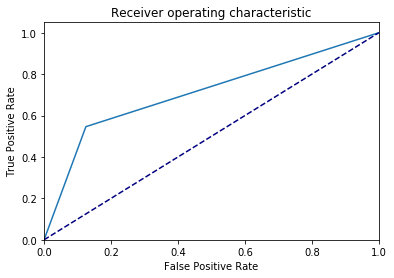

In [47]:
y_pred_knn=clf3.predict(X_test)
evaluate_method(y_test,y_pred_knn)
plot_roc(y_test,y_pred_knn)

**Plotting precision-recall curve**

AUPR=  0.6215487721782522


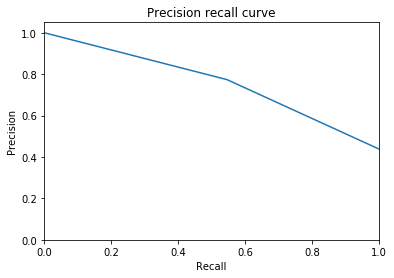

In [48]:
plot_prec_recall_curve(y_test,y_pred_knn)

### 3) Training Discriminant analysis LDA 

In [49]:
clf5=LDA(n_components=1) 
clf5.fit(X_train,y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=1, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

**Prediction and measuring performances for LDA**

F-measure=  0.6554159186116099
Accuracy=  0.6839563093473846
auc= 0.6841190911697131


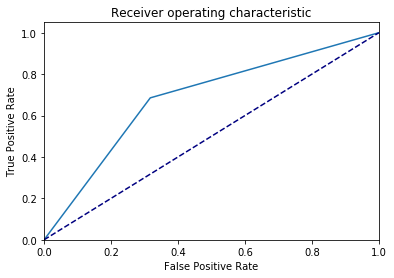

In [50]:
y_pred_lda=clf5.predict(X_test)
evaluate_method(y_test,y_pred_lda)
plot_roc(y_test,y_pred_lda)


**Plotting precision recall curve**

AUPR=  0.5683288724888977


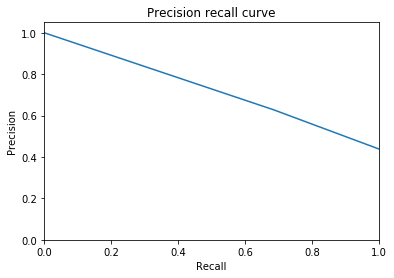

In [51]:
plot_prec_recall_curve(y_test,y_pred_lda)

### 4) Random forest 

**Tuning hyperparameters for Random Forest**

In [51]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
rf = RandomForestClassifier()

In [52]:
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   3.9s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   4.0s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_d

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.2min


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   3.9s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   3.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   3.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   7.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samp

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 11.0min


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   4.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   4.4s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   8.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   8.5s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, 

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 26.2min


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   4.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   4.5s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   4.4s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   8.8s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samp

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 47.8min


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   7.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=  41.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=  12.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=  12.2s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max

[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 64.8min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110], 'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': [100, 200, 300, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [53]:
best_grid = grid_search.best_params_
best_grid

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 100}

**Training Random forest with the tuned hyperparametrers**

In [96]:
rf=RandomForestClassifier(bootstrap=True,max_depth=80,max_features=3,min_samples_leaf=3,min_samples_split=10,n_estimators=100)

In [97]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=80, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

**Prediction , measuring performances and ROC curve**

F-measure=  0.632752826153376
Accuracy=  0.7360996761622483
auc= 0.7122617462647504


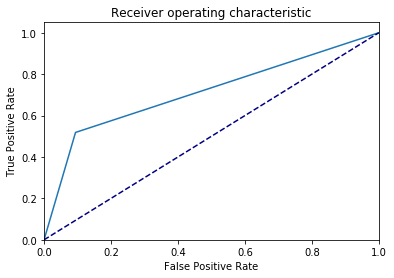

In [98]:
y_pred_rf=rf.predict(X_test)
evaluate_method(y_test,y_pred_rf)
plot_roc(y_test,y_pred_rf)

**Plotting precision recall curve** 

AUPR=  0.6307773454177337


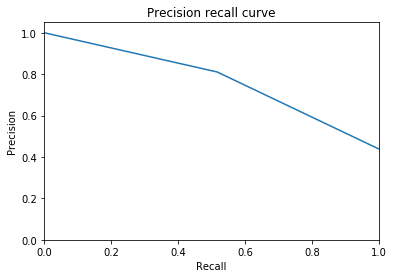

In [55]:
plot_prec_recall_curve(y_test,y_pred_rf)